# 数据预处理

X_train shape: (9531, 200, 1, 96)
Y_train shape: (9531, 49)
X_test shape: (2383, 200, 1, 96)
Y_test shape: (2383, 49)


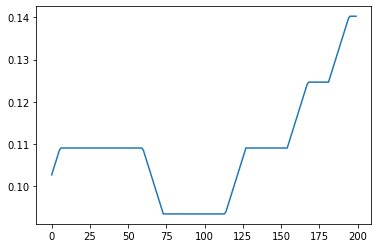

In [1]:
import h5py
import numpy as np
import tensorflow as tf 
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling2D, concatenate, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

file = h5py.File('DB2/wavelet_acc_200_96.h5','r')
imageData   = file['imageData'][:]
imageLabel  = file['imageLabel'][:]  

file.close()

# 随机打乱数据和标签
N = imageData.shape[0]
index = np.random.permutation(N)
data  = imageData[index,:,:]
label = imageLabel[index]

# 对数据升维,标签one-hot
data  = np.expand_dims(data, axis=2)
label = convert_to_one_hot(label,49).T

# 划分数据集
N = data.shape[0]
num_train = round(N*0.8)
X_train = data[0:num_train,:,:]
Y_train = label[0:num_train,:]
X_test  = data[num_train:N,:,:]
Y_test  = label[num_train:N,:]

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

plt.plot(X_train[0, :, 0, 0])

In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss') 
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


# 建立模型

In [3]:
def CNN(input_shape=(200,1,96), classes=49): 
    X_input = Input(input_shape)
    
    X = Conv2D(filters=32,kernel_size=(20,1),strides=(1,1),padding='same',activation='relu',name='conv1')(X_input)
    X = MaxPooling2D(pool_size=(10,1), strides=(10,1), name='pool1')(X)
    
    X = Conv2D(filters=64,kernel_size=(6,1),strides=(1,1),padding='same',activation='relu',name='conv2')(X)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), name='pool2')(X)
    
    X = Conv2D(filters=128,kernel_size=(3,1),strides=(1,1),padding='same',activation='relu',name='conv3')(X)
    X = MaxPooling2D(pool_size=(2,1), strides=(2,1), name='pool3')(X)
    
    X = Flatten(name='flatten')(X)
    X = Dropout(0.5)(X)
    X = Dense(128,activation='relu',name='fc1')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc2')(X)
    
    model = Model(inputs=X_input, outputs=X, name='CNN')
    return model
model = CNN(input_shape = (200, 1, 96), classes = 49)
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 1, 96)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 200, 1, 32)        61472     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 20, 1, 32)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 20, 1, 64)         12352     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 10, 1, 64)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 1, 128)        24704     
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 5, 1, 128)         0       

# 训练原始数据

In [4]:
import time
start = time.time()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = LossHistory() # 创建一个history实例

model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1, 
            validation_data=(X_test, Y_test),callbacks=[history])

preds_train = model.evaluate(X_train, Y_train)
print("Train Loss = " + str(preds_train[0]))
print("Train Accuracy = " + str(preds_train[1]))

preds_test  = model.evaluate(X_test, Y_test)
print("Test Loss = " + str(preds_test[0]))
print("Test Accuracy = " + str(preds_test[1]))


end = time.time()
print("time:",end-start)

Epoch 1/100
149/149 [==============================] - 12s 73ms/step - loss: 3.4627 - accuracy: 0.0937 - val_loss: 2.4245 - val_accuracy: 0.2812
Epoch 2/100
149/149 [==============================] - 9s 63ms/step - loss: 2.2956 - accuracy: 0.2957 - val_loss: 1.6048 - val_accuracy: 0.5052
Epoch 3/100
149/149 [==============================] - 9s 63ms/step - loss: 1.7168 - accuracy: 0.4506 - val_loss: 1.4102 - val_accuracy: 0.5669
Epoch 4/100
149/149 [==============================] - 9s 60ms/step - loss: 1.4173 - accuracy: 0.5491 - val_loss: 1.0205 - val_accuracy: 0.6790
Epoch 5/100
149/149 [==============================] - 10s 64ms/step - loss: 1.1587 - accuracy: 0.6220 - val_loss: 0.9233 - val_accuracy: 0.6890
Epoch 6/100
149/149 [==============================] - 9s 59ms/step - loss: 1.0400 - accuracy: 0.6616 - val_loss: 0.7462 - val_accuracy: 0.7608
Epoch 7/100
149/149 [==============================] - 9s 60ms/step - loss: 0.9121 - accuracy: 0.6998 - val_loss: 0.6626 - val_accurac

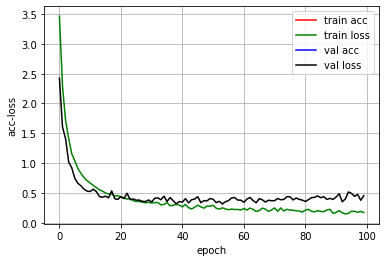

In [5]:
history.loss_plot('epoch')